<a href="https://colab.research.google.com/github/tewei0328/teach-programming/blob/main/getdata_finmind_stock_option_future_normalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-引入函式庫

In [ ]:
# ! pip install backtesting
import datetime
import warnings

import pandas as pd
import requests
#from backtesting import Backtest, Strategy
#from backtesting.lib import crossover
#from backtesting.test import SMA
#from pandas.core.common import SettingWithCopyWarning

#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option("display.max_columns", None)

## 1-股票
def getdata_stock(stock_index,end_month,end_day):
  #stock_index = '03663B'
  url = "https://api.finmindtrade.com/api/v4/data"
  parameter = {
      "dataset": "TaiwanStockPrice",
      "start_date": datetime.datetime(2025, 1, 1, 0, 0).strftime("%Y-%m-%d"),
      "end_date": datetime.datetime(2025, end_month, end_day, 0, 0).strftime("%Y-%m-%d"),
      "data_id": stock_index,
  }

  data = requests.get(url, params=parameter)
  data = data.json()

  df1 = pd.DataFrame(data["data"])
  df1.index = pd.to_datetime(df1["date"])
  df1.rename(
      columns={
          "Trading_Volume": "Volume",
          "open": "Open",
          "max": "High",
          "min": "Low",
          "close": "Close",
      },
      inplace=True,
  )

  df1.drop(
      columns=["stock_id", "date", "Trading_money", "spread", "Trading_turnover"],
      inplace=True,
  )
  return df1


## 2-選擇權
def getdata_option(stock_index,end_month,end_day):
  stock_index = "TXO"
  url = "https://api.finmindtrade.com/api/v4/data"
  parameter = {
      "dataset": "TaiwanOptionDaily",
      "start_date": datetime.datetime(2025, 1, 1, 0, 0).strftime("%Y-%m-%d"),
      "end_date": datetime.datetime(2025, 4, 23, 0, 0).strftime("%Y-%m-%d"),
      "data_id": stock_index,
  }

  data = requests.get(url, params=parameter)
  data = data.json()

  df = pd.DataFrame(data["data"])

  df.index = pd.to_datetime(df["date"])
  df.rename(
      columns={
          "open": "Open",
          "max": "High",
          "min": "Low",
          "close": "Close",
      },
      inplace=True,
  )

  df.drop(
      #columns=["option_id", "date", "settlement_price", "open_interest", "trading_session"],
      columns=["option_id", "date", "settlement_price", "open_interest"],
      inplace=True,
  )
  return df

def get_options(df, contract_period, put_or_call, strike_price, trade_period):

    option_df = df.loc[(df['contract_date'] == contract_period) & \
                       (df['call_put'] == put_or_call) & \
                       (df['strike_price'] == strike_price) & \
                       (df['trading_session'] == trade_period) ]

    option_df.drop(
      #columns=["option_id", "date", "settlement_price", "open_interest", "trading_session"],
      columns=["call_put", "trading_session", "contract_date", "strike_price"],
      inplace=True,
)
    return option_df


## 3-期貨
def getdata_future(end_month,end_day):
  stock_index = "TX"
  url = "https://api.finmindtrade.com/api/v4/data"
  parameter = {
      "dataset": "TaiwanFuturesDaily",
      "start_date": datetime.datetime(2025, 1, 1, 0, 0).strftime("%Y-%m-%d"),
      "end_date": datetime.datetime(2025, end_month, end_day, 0, 0).strftime("%Y-%m-%d"),
      "data_id": stock_index,
  }

  data = requests.get(url, params=parameter)
  data = data.json()

  df = pd.DataFrame(data["data"])


  df = df[(df.settlement_price > 0)]
  df = df[df['contract_date'] == df.groupby('date')['contract_date'].transform('min')]

  df.index = pd.to_datetime(df["date"])

  df.drop(
      #columns=["option_id", "date", "settlement_price", "open_interest", "trading_session"],
      columns=["trading_session", "contract_date","futures_id", "date", "settlement_price", "open_interest","open","max","min","spread","spread_per","volume"],
      inplace=True,
  )
  df.rename(
        columns={
            "close": "Close",
        },
        inplace=True,
    )

  return df


# 2-plot

<ipython-input-1-d1fccc523411>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_df.drop(


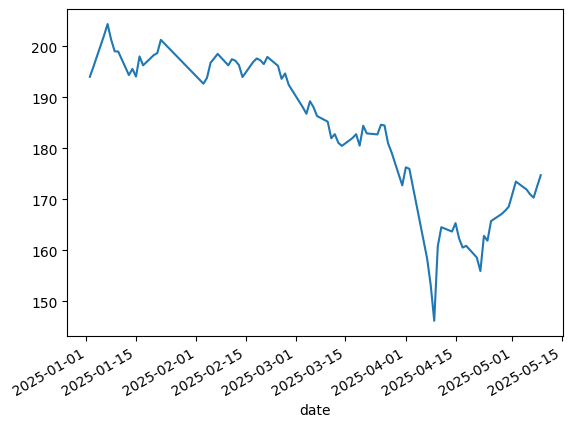

In [ ]:
df_3b=getdata_stock('03663B',5,11)
df_50=getdata_stock('0050',5,11)
#df1.Close.plot()
df_50.Close.plot()
df_op=getdata_option('TXO',5,11)
df_put=get_options(df_op, '202505', 'put', 20000, 'position')
df_fut = getdata_future(5,11)

<Axes: xlabel='date'>

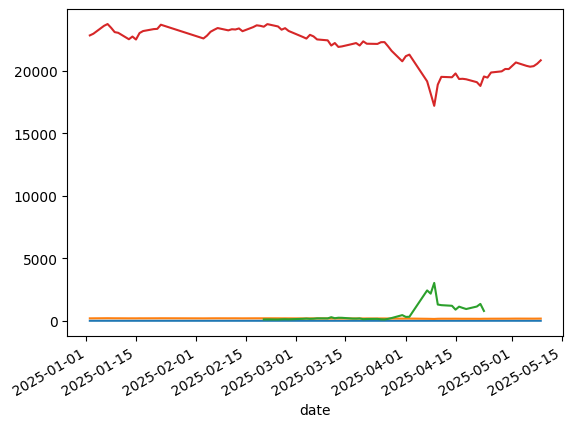

In [ ]:
df_3b.Close.plot()
df_50.Close.plot()
df_put.Close.plot()
df_fut.Close.plot()

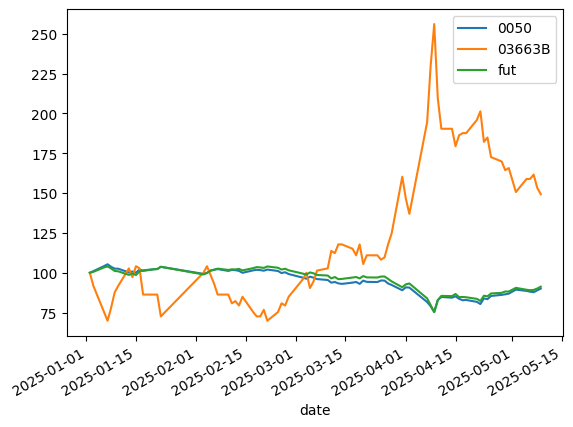

In [ ]:
import matplotlib.pyplot as plt
# 對所有欄位進行正規化
# 使用第一天的資料作為基準
df_50n = df_50 / df_50.iloc[0] * 100
df_3bn = df_3b / df_3b.iloc[0] * 100
df_putn = df_put / df_put.iloc[0] * 100
df_futn = df_fut / df_fut.iloc[0] * 100

# 繪製正規化後的資料
df_50n['Close'].plot(legend='0050')
df_3bn.Close.plot(legend='03663B')
#df_putn.Close.plot(legend='put')
df_futn.Close.plot(legend='fut')

plt.legend(["0050","03663B","fut"])

<Axes: xlabel='date'>

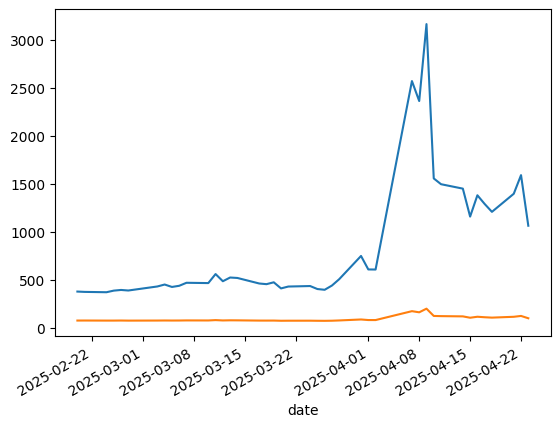

In [ ]:
dfn_sum=df_3bn+df_50n+df_putn+df_futn
dfn_sum.Close.plot()
dfn_sum1=df_3bn*0.05+df_50n*0.7+df_putn*0.05+df_futn*0
dfn_sum1.Close.plot()